In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import preprocessing
from keras import optimizers
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.merge import concatenate
from random import shuffle

Using TensorFlow backend.


In [8]:
data = np.load('small_sims/training.data.npz')
#s12mat,s21mat,sNomat,s12pos,s21pos,sNopos,s12_target,s21_target,sNo_target = [data[i] for i in ['s12mat', 's21mat', 'sNomat', 's12pos', 's21pos', 'sNopos', 's12_target', 's21_target', 'sNo_target']]

xdata = data['x']
ytarget = data['target']
s = xdata.shape

xdata,ytarget = np.reshape(xdata, newshape=(s[0], s[1], s[2], 1)), np.reshape(ytarget, newshape=(s[0], s[1], s[2], 1))

xdata_train,ytarget_train = xdata[1000:], ytarget[1000:]
xdata_test, ytarget_test  = xdata[:1000], ytarget[:1000] 

xdata_test.shape

(1000, 48, 128, 1)

In [9]:
#data = np.load('small_sims/training.data.npz')
#s12mat,s21mat,sNomat,s12pos,s21pos,sNopos,s12_target,s21_target,sNo_target = [data[i] for i in ['s12mat', 's21mat', 'sNomat', 's12pos', 's21pos', 'sNopos', 's12_target', 's21_target', 'sNo_target']]

#xdata = []
#ytarget = []

#xdata, ytarget = map(np.array, [xdata, ytarget])

#z = list(range(len(xdata)))
#shuffle(z)

#tmpx, tmpy = [],[]
#for idx in range(3000):
#    ix, iy = [],[]
#    for j in xdata[idx]: ix.append(j[:128])
#    for j in ytarget[idx]: iy.append(j[:128])
#    tmpx.append(np.array(ix))
#    tmpy.append(np.array(iy))
#xdata, ytarget = np.array(tmpx), np.array(tmpy)
#s = xdata.shape
#xdata,ytarget = np.reshape(xdata[z], newshape=(s[0], s[1], s[2], 1)), np.reshape(ytarget[z], newshape=(s[0], s[1], s[2], 1))

#xdata_train,ytarget_train = xdata[:2500], ytarget[:2500]
#xdata_test, ytarget_test  = xdata[2500:], ytarget[2500:] 

#xdata_train.shape,ytarget_train.shape

In [10]:
inputs = Input((s[1],s[2],1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'mean_squared_error')
model.summary()

W0923 09:44:14.944551 140041921095488 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 09:44:14.963579 140041921095488 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 09:44:14.968994 140041921095488 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0923 09:44:15.014640 140041921095488 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0923 09:44:15.111862 140041921095488 deprecation_wrapper.py:119] From /usr/

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 128, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 128, 64)  36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 24, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [11]:
model.fit(xdata_train, ytarget_train, batch_size=16,
          epochs=15, verbose=1,
          validation_data=(xdata_test, ytarget_test))


W0923 09:44:21.316555 140041921095488 deprecation.py:323] From /home/flagel/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 19000 samples, validate on 1000 samples
Epoch 1/17
19000/19000 [==============================] - 6795s 358ms/step - loss: 0.1251 - val_loss: 0.1246
Epoch 2/17
19000/19000 [==============================] - 7256s 382ms/step - loss: 0.1244 - val_loss: 0.1243
Epoch 3/17
19000/19000 [==============================] - 6805s 358ms/step - loss: 0.1242 - val_loss: 0.1241
Epoch 4/17
19000/19000 [==============================] - 6801s 358ms/step - loss: 0.1894 - val_loss: 0.2737
Epoch 5/17
 2928/19000 [===>..........................] - ETA: 1:36:46 - loss: 0.2705

KeyboardInterrupt: 

In [12]:
p = model.predict(xdata_test[20:40])

In [13]:
from matplotlib import pyplot as plt


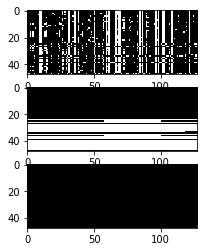

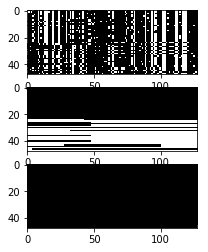

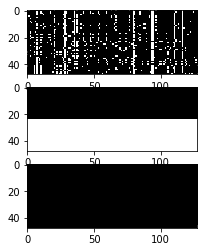

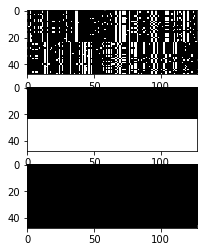

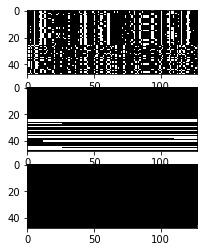

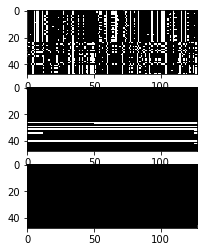

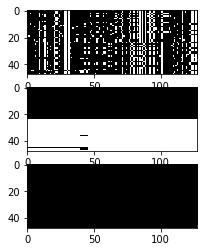

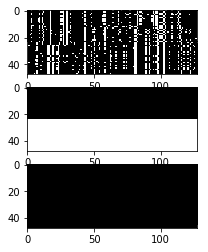

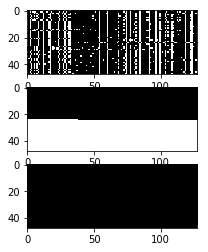

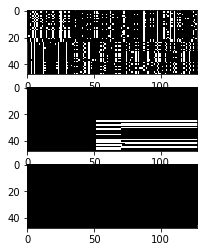

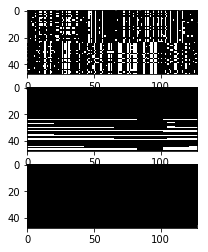

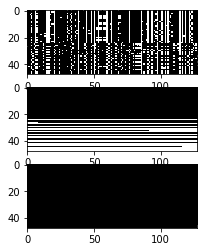

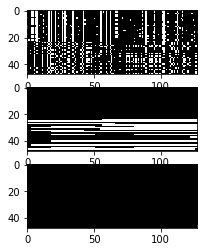

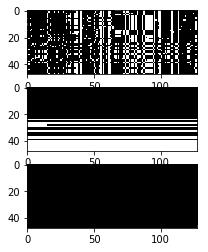

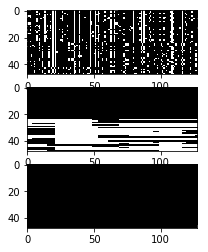

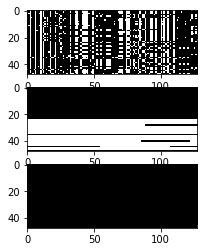

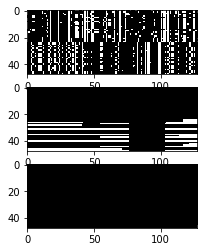

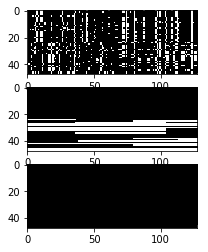

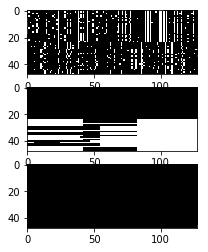

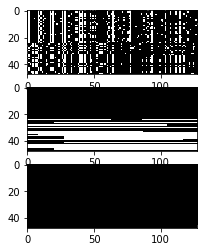

In [14]:
for i in range(20):
  plt.subplot(3,1,1)
  plt.imshow(np.reshape(xdata_test[i], (48, 128)), aspect=1, cmap='bone')

  plt.subplot(3,1,2)
  plt.imshow(np.reshape(ytarget_test[i], (48, 128)), aspect=1, cmap='bone')

  plt.subplot(3,1,3)
  plt.imshow(np.reshape(p[i],  (48, 128)), aspect=1, cmap='bone')
  plt.show()